# 다회용기 검증 모델 학습

이 노트북은 용기 이미지를 **일회용(disposable)** vs **다회용(reusable)**으로 분류하는 모델을 학습합니다.

## 데이터셋 구조
```
data_preprocessed/container_type/
├── disposable/  (일회용)
└── reusable/    (다회용)
```

## 모델 아키텍처
- **베이스 모델**: ResNetV2-101 BiT (Google Big Transfer, 42M params)
- **Pretrained**: ImageNet-21K (21,000 클래스, 14M 이미지) → ImageNet-1K fine-tuned
- **분류**: Binary classification (disposable vs reusable)
- **데이터 증강**: 회전, 뒤집기, 밝기 조정 등

## 1. 환경 설정 및 라이브러리 import

In [1]:
#############################################
# 🔧 실험 설정 - 학습 전에 이 값을 수정하세요!
#############################################
from datetime import datetime

# 실험 이름 (날짜_설명 형식 권장)
EXPERIMENT_NAME = datetime.now().strftime("%Y%m%d") + "_reusable_v1"
# 예: "20251203_reusable_v1", "20251210_augmentation_test"

print(f"📁 실험 이름: {EXPERIMENT_NAME}")
print(f"   결과 저장 위치: /app/training_outputs/{EXPERIMENT_NAME}/")
#############################################

import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import timm  # ImageNet-21K pretrained 모델용

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Device 설정 (CPU/GPU 자동 감지)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("   ℹ️ CPU 모드로 학습합니다. 시간이 더 걸릴 수 있습니다.")

📁 실험 이름: 20251203_reusable_v1
   결과 저장 위치: /app/training_outputs/20251203_reusable_v1/

🖥️ Using device: cpu
   ℹ️ CPU 모드로 학습합니다. 시간이 더 걸릴 수 있습니다.


## 🔧 메모리 관리 (선택사항)

GPU 사용 시 메모리 부족하면 아래 셀을 실행하세요. CPU 모드에서는 건너뛰어도 됩니다.

In [2]:
# 메모리 관리 유틸리티 (GPU가 있을 때만 동작)
import gc

def clear_memory():
    """메모리 정리 (CPU/GPU 모두 지원)"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f}GB / {torch.cuda.get_device_properties(0).total_memory/1e9:.2f}GB")
    else:
        print("CPU 모드 - GPU 메모리 관리 불필요")

clear_memory()

CPU 모드 - GPU 메모리 관리 불필요


## 📷 데이터 전처리 (선택사항)

새로운 원본 이미지가 있으면 아래 셀을 실행하여 전처리합니다.
- YOLO를 사용해 용기(bottle, cup)를 감지
- 하나의 용기만 있는 이미지만 크롭하여 저장
- 이미 전처리된 데이터가 있으면 **건너뛰어도 됩니다**


In [3]:
# 🔧 전처리 설정
PREPROCESS_INPUT_DIR = '/app/data/container_type'  # 원본 이미지 위치
PREPROCESS_OUTPUT_DIR = '/app/data_preprocessed/container_type'  # 전처리 결과 위치
SKIP_PREPROCESSING = True # True: 건너뛰기, False: 전처리 실행

if not SKIP_PREPROCESSING:
    import sys
    sys.path.append('/app/scripts')
    from preprocess_container_images import ContainerPreprocessor
    
    # CPU/GPU 자동 선택
    preprocess_device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"🔄 전처리 시작...")
    print(f"   입력: {PREPROCESS_INPUT_DIR}")
    print(f"   출력: {PREPROCESS_OUTPUT_DIR}")
    print(f"   Device: {preprocess_device}")
    
    preprocessor = ContainerPreprocessor(
        model_name='yolov8m.pt',  # Medium 모델 (26M params, mAP 50.2)
        confidence_threshold=0.25,
        device=preprocess_device
    )
    
    preprocessor.process_directory(
        input_dir=PREPROCESS_INPUT_DIR,
        output_dir=PREPROCESS_OUTPUT_DIR,
        recursive=True,
        padding_ratio=0.1
    )
    print("✅ 전처리 완료!")
else:
    print("⏭️ 전처리 건너뜀 (SKIP_PREPROCESSING=True)")
    print(f"   기존 데이터 사용: /app/data_preprocessed/container_type")


⏭️ 전처리 건너뜀 (SKIP_PREPROCESSING=True)
   기존 데이터 사용: /app/data_preprocessed/container_type


## 2. 하이퍼파라미터 설정

In [4]:
# 경로 설정
DATA_DIR = Path('/app/data_preprocessed/container_type')

# 🔹 학습 결과는 training_outputs에 저장 (배포용 models/weights와 분리)
MODEL_SAVE_DIR = Path(f'/app/training_outputs/{EXPERIMENT_NAME}')
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# 학습 하이퍼파라미터
BATCH_SIZE = 8  # ResNet-101은 메모리를 더 사용하므로 배치 크기 감소
IMG_SIZE = 224
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
TRAIN_RATIO = 0.8
PATIENCE = 10  # Early stopping patience

# 클래스 정의
CLASSES = ['disposable', 'reusable']
NUM_CLASSES = len(CLASSES)

print(f"📂 Data directory: {DATA_DIR}")
print(f"💾 Model save directory: {MODEL_SAVE_DIR}")
print(f"   (배포용 모델 위치: /app/models/weights - 여기에 덮어씌워지지 않음)")
print(f"\n🏷️ Classes: {CLASSES}")
print(f"⚙️ Batch size: {BATCH_SIZE}, Image size: {IMG_SIZE}")
print(f"⚙️ Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE}")

📂 Data directory: /app/data_preprocessed/container_type
💾 Model save directory: /app/training_outputs/20251203_reusable_v1
   (배포용 모델 위치: /app/models/weights - 여기에 덮어씌워지지 않음)

🏷️ Classes: ['disposable', 'reusable']
⚙️ Batch size: 8, Image size: 224
⚙️ Epochs: 50, Learning rate: 0.0001


## 3. 데이터셋 클래스 정의

In [5]:
class ContainerTypeDataset(Dataset):
    """용기 타입 분류 데이터셋"""
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.classes = CLASSES
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # 이미지 경로와 레이블 수집
        self.samples = []
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            if not class_dir.exists():
                print(f"Warning: {class_dir} does not exist")
                continue
                
            for img_path in class_dir.glob('*.png'):
                self.samples.append((str(img_path), self.class_to_idx[class_name]))
        
        print(f"Total samples: {len(self.samples)}")
        
        # 클래스별 개수 출력
        class_counts = {cls: 0 for cls in self.classes}
        for _, label in self.samples:
            class_counts[self.classes[label]] += 1
        print("Class distribution:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # 이미지 로드
        image = Image.open(img_path).convert('RGB')
        
        # Transform 적용
        if self.transform:
            image = self.transform(image)
        
        return image, label

## 4. 데이터 증강 및 전처리

In [6]:
# Training transform (데이터 증강)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transform (증강 없음)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined")

Transforms defined


## 5. 데이터셋 로드 및 분할

In [7]:
# 전체 데이터셋 로드 (transform 없이)
full_dataset = ContainerTypeDataset(DATA_DIR, transform=None)

# Train/Val 분할
train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size

train_indices, val_indices = random_split(
    range(len(full_dataset)), 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Transform 적용한 데이터셋 생성
class SubsetDataset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[self.indices[idx]]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = SubsetDataset(full_dataset, train_indices.indices, train_transform)
val_dataset = SubsetDataset(full_dataset, val_indices.indices, val_transform)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Total samples: 271
Class distribution:
  disposable: 77
  reusable: 194

Train samples: 216
Validation samples: 55
Train batches: 27
Val batches: 7


## 6. 샘플 이미지 시각화

Training samples:


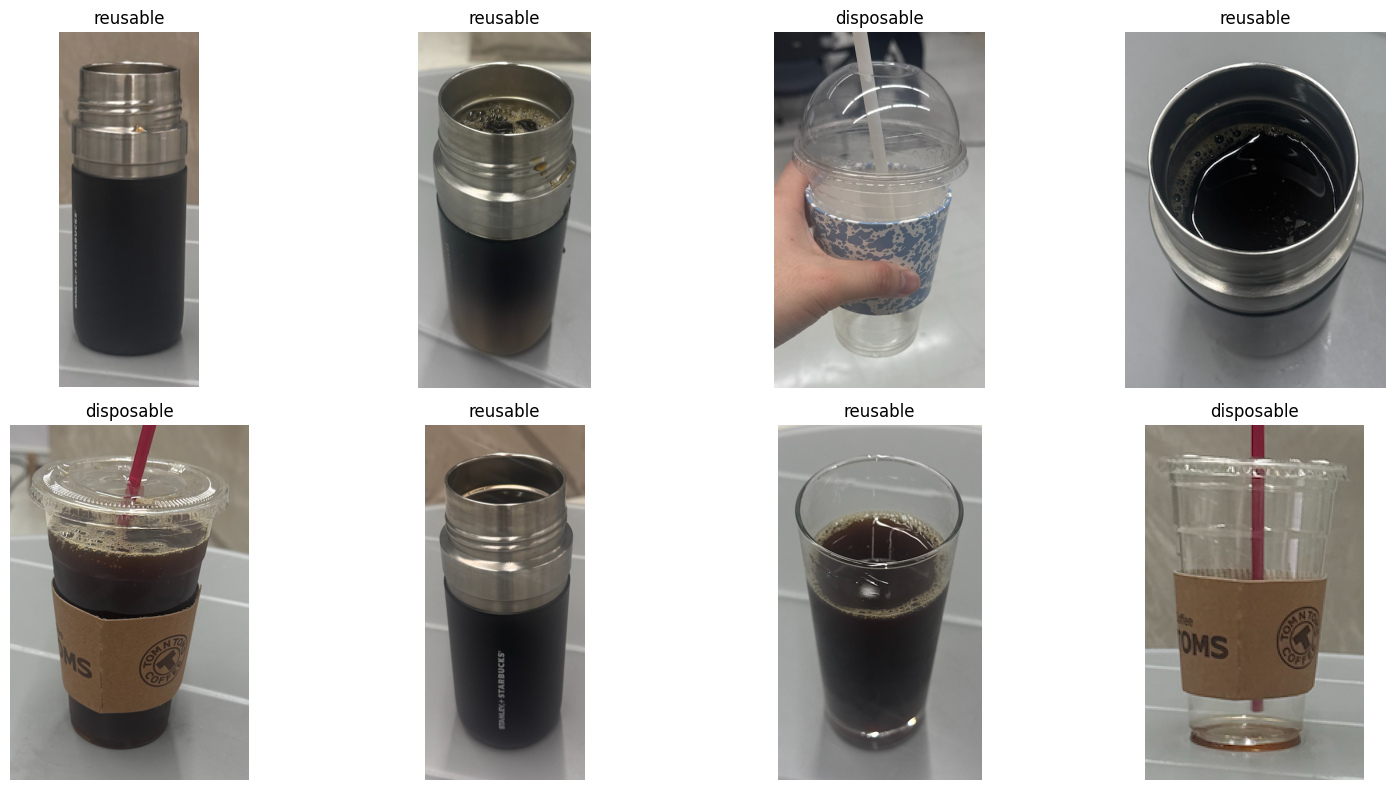

In [8]:
# 샘플 이미지 시각화
def show_samples(dataset, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(min(n_samples, len(dataset))):
        img_path, label = dataset.dataset.samples[dataset.indices[i]]
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{CLASSES[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Training samples:")
show_samples(train_dataset)

## 7. 모델 정의

In [9]:
class ReusableClassifier(nn.Module):
    """다회용기 분류 모델 (ResNetV2-101 BiT + ImageNet-21K pretrained)"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(ReusableClassifier, self).__init__()
        
        # timm의 ResNetV2-101 BiT (Big Transfer)
        # ImageNet-21K (14M 이미지, 21K 클래스)로 사전학습 → ImageNet-1K로 미세조정
        self.backbone = timm.create_model(
            'resnetv2_101x1_bit.goog_in21k_ft_in1k',
            pretrained=pretrained,
            num_classes=num_classes,
            drop_rate=0.3
        )
    
    def forward(self, x):
        return self.backbone(x)

# 모델 생성
model = ReusableClassifier(num_classes=NUM_CLASSES, pretrained=True)
model = model.to(device)

print(f"🚀 Model: ResNetV2-101 BiT (ImageNet-21K → ImageNet-1K)")
print(f"   Pretrained on 21K classes, 14M images (Google BiT)")
print(f"   Device: {device}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

🚀 Model: ResNetV2-101 BiT (ImageNet-21K → ImageNet-1K)
   Pretrained on 21K classes, 14M images (Google BiT)
   Device: cpu
   Total parameters: 42,496,578
   Trainable parameters: 42,496,578


## 8. Loss, Optimizer, Scheduler 설정

In [10]:
# 클래스 가중치 계산 (불균형 데이터 대응)
class_counts = [0] * NUM_CLASSES
for _, label in train_dataset:
    class_counts[label] += 1

class_weights = [len(train_dataset) / count for count in class_counts]
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print("Loss, optimizer, and scheduler configured")

Class counts: [63, 153]
Class weights: tensor([3.4286, 1.4118])
Loss, optimizer, and scheduler configured


## 9. 학습 및 검증 함수

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """1 epoch 학습"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """1 epoch 검증"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

print("Training and validation functions defined")

Training and validation functions defined


## 10. 학습 루프

In [12]:
# 학습 히스토리 저장
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0

print("Starting training...\n")

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"{'='*60}")
    
    # 학습
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 검증
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # 결과 출력
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Best model 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        
        # 모델 저장
        save_path = MODEL_SAVE_DIR / 'reusable_classifier_best.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, save_path)
        print(f"✅ Best model saved! (Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        break

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best Val Loss: {best_val_loss:.4f}")
print(f"Best Val Acc: {best_val_acc:.2f}%")
print(f"{'='*60}")

Starting training...


Epoch [1/50]


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s, loss=1.5298, acc=94.55%]



Train Loss: 0.4038, Train Acc: 87.04%
Val Loss: 0.4271, Val Acc: 94.55%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.4271, Val Acc: 94.55%)

Epoch [2/50]


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s, loss=1.1007, acc=92.73%]



Train Loss: 0.1033, Train Acc: 97.22%
Val Loss: 0.3101, Val Acc: 92.73%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.3101, Val Acc: 92.73%)

Epoch [3/50]


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s, loss=1.3394, acc=94.55%]



Train Loss: 0.1294, Train Acc: 96.30%
Val Loss: 0.2566, Val Acc: 94.55%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.2566, Val Acc: 94.55%)

Epoch [4/50]


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s, loss=1.4647, acc=98.18%] 



Train Loss: 0.0226, Train Acc: 99.54%
Val Loss: 0.2135, Val Acc: 98.18%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.2135, Val Acc: 98.18%)

Epoch [5/50]


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s, loss=1.5450, acc=94.55%] 



Train Loss: 0.0795, Train Acc: 98.61%
Val Loss: 0.2776, Val Acc: 94.55%
Current LR: 0.000100
No improvement. Patience: 1/10

Epoch [6/50]


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it, loss=1.8675, acc=96.36%] 



Train Loss: 0.0010, Train Acc: 100.00%
Val Loss: 0.2961, Val Acc: 96.36%
Current LR: 0.000100
No improvement. Patience: 2/10

Epoch [7/50]


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it, loss=1.5846, acc=94.55%] 



Train Loss: 0.1887, Train Acc: 95.83%
Val Loss: 0.4076, Val Acc: 94.55%
Current LR: 0.000100
No improvement. Patience: 3/10

Epoch [8/50]


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it, loss=2.5459, acc=94.55%]



Train Loss: 0.0752, Train Acc: 97.22%
Val Loss: 0.7634, Val Acc: 94.55%
Current LR: 0.000100
No improvement. Patience: 4/10

Epoch [9/50]


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it, loss=2.8850, acc=92.73%]



Train Loss: 0.0013, Train Acc: 100.00%
Val Loss: 0.8862, Val Acc: 92.73%
Current LR: 0.000100
No improvement. Patience: 5/10

Epoch [10/50]


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it, loss=2.9547, acc=92.73%]


Epoch 00010: reducing learning rate of group 0 to 5.0000e-05.

Train Loss: 0.0004, Train Acc: 100.00%
Val Loss: 0.9265, Val Acc: 92.73%
Current LR: 0.000050
No improvement. Patience: 6/10

Epoch [11/50]


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it, loss=2.0412, acc=80.00%]



Train Loss: 0.1026, Train Acc: 96.76%
Val Loss: 0.6691, Val Acc: 80.00%
Current LR: 0.000050
No improvement. Patience: 7/10

Epoch [12/50]


Validation: 100%|██████████| 7/7 [00:09<00:00,  1.29s/it, loss=1.2956, acc=96.36%] 



Train Loss: 0.1375, Train Acc: 96.76%
Val Loss: 0.2261, Val Acc: 96.36%
Current LR: 0.000050
No improvement. Patience: 8/10

Epoch [13/50]


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it, loss=1.5306, acc=90.91%] 



Train Loss: 0.0400, Train Acc: 98.61%
Val Loss: 0.3180, Val Acc: 90.91%
Current LR: 0.000050
No improvement. Patience: 9/10

Epoch [14/50]


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it, loss=1.9134, acc=98.18%] 


Train Loss: 0.0102, Train Acc: 100.00%
Val Loss: 0.2943, Val Acc: 98.18%
Current LR: 0.000050
No improvement. Patience: 10/10

⚠️ Early stopping triggered after 14 epochs

Training completed!
Best Val Loss: 0.2135
Best Val Acc: 98.18%


## 11. 학습 곡선 시각화

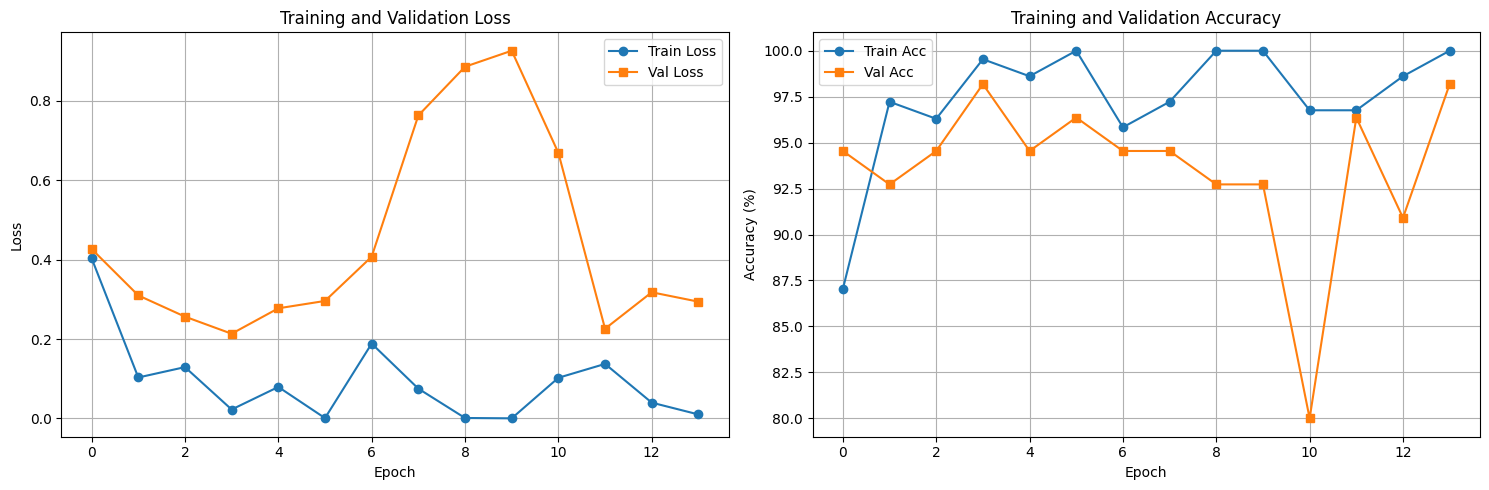

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss 곡선
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy 곡선
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'reusable_classifier_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. 최종 모델 평가

In [14]:
# Best model 로드
checkpoint = torch.load(MODEL_SAVE_DIR / 'reusable_classifier_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded (Epoch {checkpoint['epoch']+1})")

# 최종 평가
val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)

print(f"\nFinal Validation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.2f}%")

# Classification Report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(val_labels, val_preds, target_names=CLASSES, digits=4))

Best model loaded (Epoch 4)


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it, loss=1.4647, acc=98.18%] 


Final Validation Results:
Loss: 0.2135
Accuracy: 98.18%

Classification Report:
              precision    recall  f1-score   support

  disposable     1.0000    0.9286    0.9630        14
    reusable     0.9762    1.0000    0.9880        41

    accuracy                         0.9818        55
   macro avg     0.9881    0.9643    0.9755        55
weighted avg     0.9823    0.9818    0.9816        55



## 13. Confusion Matrix 시각화

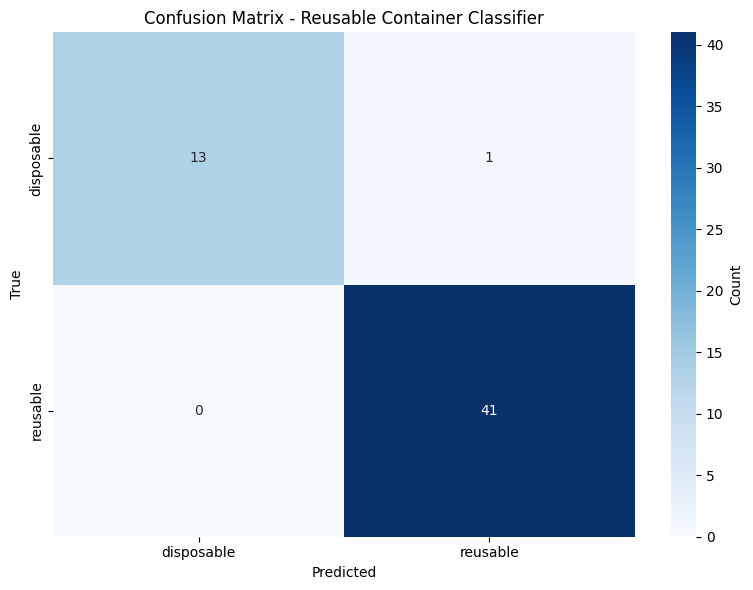

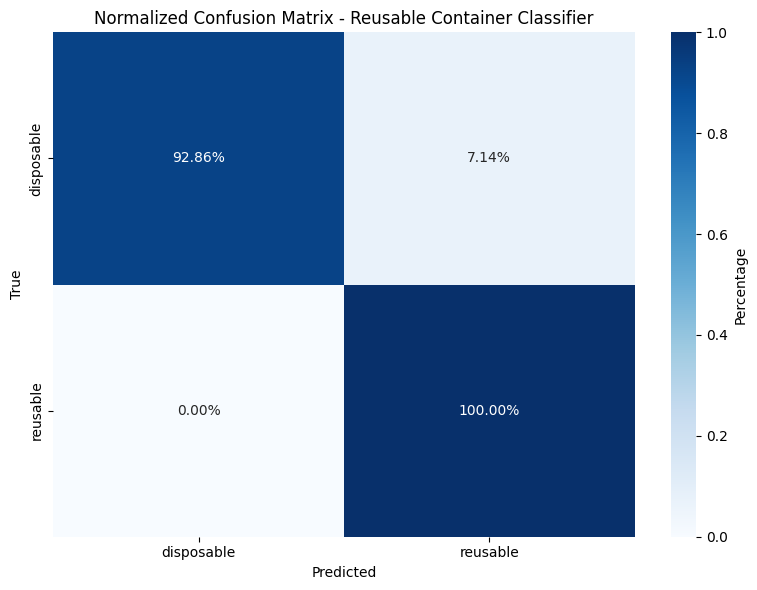

In [15]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Reusable Container Classifier')
plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'reusable_classifier_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix - Reusable Container Classifier')
plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'reusable_classifier_confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. 학습 메타데이터 저장

In [16]:
# 메타데이터 저장
metadata = {
    'model_name': 'reusable_classifier',
    'architecture': 'ResNetV2-101 BiT (ImageNet-21K pretrained)',
    'timm_model': 'resnetv2_101x1_bit.goog_in21k_ft_in1k',
    'num_classes': NUM_CLASSES,
    'classes': CLASSES,
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history['train_loss']),
    'learning_rate': LEARNING_RATE,
    'best_val_loss': best_val_loss,
    'best_val_acc': best_val_acc,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'class_counts': class_counts,
}

with open(MODEL_SAVE_DIR / 'reusable_classifier_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Metadata saved to reusable_classifier_metadata.json")
print(json.dumps(metadata, indent=2))

Metadata saved to reusable_classifier_metadata.json
{
  "model_name": "reusable_classifier",
  "architecture": "ResNetV2-101 BiT (ImageNet-21K pretrained)",
  "timm_model": "resnetv2_101x1_bit.goog_in21k_ft_in1k",
  "num_classes": 2,
  "classes": [
    "disposable",
    "reusable"
  ],
  "img_size": 224,
  "batch_size": 8,
  "epochs_trained": 14,
  "learning_rate": 0.0001,
  "best_val_loss": 0.21354506203871487,
  "best_val_acc": 98.18181818181819,
  "train_samples": 216,
  "val_samples": 55,
  "class_counts": [
    63,
    153
  ]
}


## 15. 샘플 예측 시각화

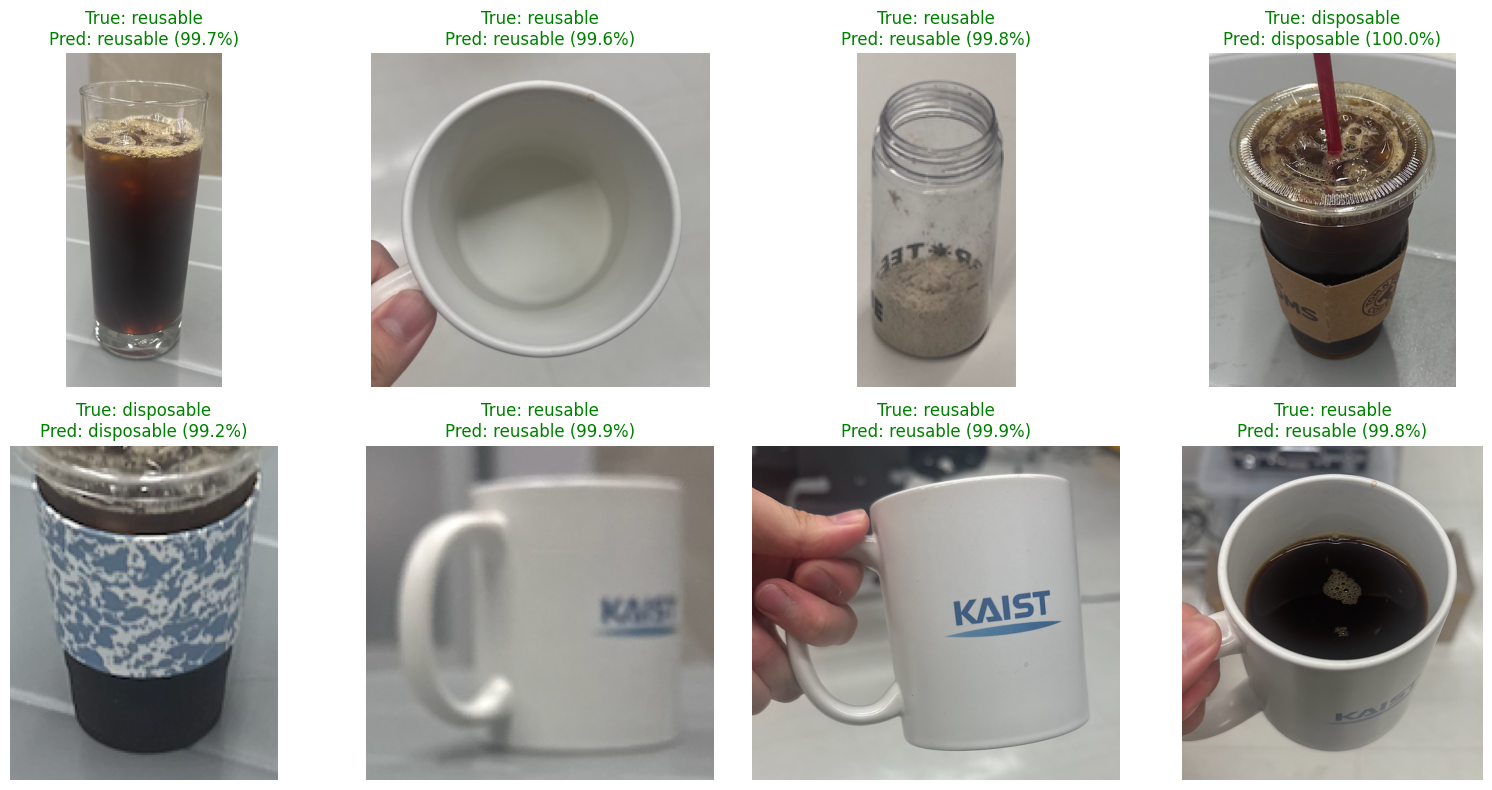

In [17]:
# 샘플 예측 시각화
model.eval()

# 샘플 선택 (validation set에서)
n_samples = 8
sample_indices = np.random.choice(len(val_dataset), n_samples, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, idx in enumerate(sample_indices):
    img_path, true_label = val_dataset.dataset.samples[val_dataset.indices[idx]]
    img = Image.open(img_path).convert('RGB')
    
    # 예측
    img_tensor = val_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_label].item()
    
    # 시각화
    axes[i].imshow(img)
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(
        f"True: {CLASSES[true_label]}\nPred: {CLASSES[pred_label]} ({confidence*100:.1f}%)",
        color=color
    )
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'reusable_classifier_sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## ✅ 완료!

다회용기 분류 모델 학습이 완료되었습니다.

### 📁 저장된 파일 위치:
`training_outputs/{EXPERIMENT_NAME}/`

- `reusable_classifier_best.pth` - 최고 성능 모델
- `reusable_classifier_metadata.json` - 모델 메타데이터
- `reusable_classifier_*.png` - 학습 곡선, confusion matrix 등

### 🚀 배포하려면:
학습된 모델을 배포 서버에 적용하려면:
```bash
cp training_outputs/{EXPERIMENT_NAME}/reusable_classifier_best.pth models/weights/
```